In [1]:
'''
Guide to use of program
Begin by running the below chunks, it should trigger instructions and entry boxes to follow

Follow Steps:

    1. Begin by entering the current date to consider most up-to-date data (Ensure it is in YYYY/MM/DD format)
    2. Begin entering the Stock Symbol (Ticker) that constitute your portfolio in ALL CAPS.
        - If you have mistakenly entered the wrong ticker, enter "Remove" to remove the last added ticker
        - Once all tickers have been entered, enter "Done" to proceed
    3. A loading bar should appear while the program is generating possible combinations of weights to create the efficient frontier
    4. Once it is done loading the overall return, variance and optimal weightage for your portfolio will appear.
'''

'\nGuide to use of program\nBegin by running the below chunks, it should trigger instructions and entry boxes to follow\n\nFollow Steps:\n\n    1. Begin by entering the current date to consider most up-to-date data (Ensure it is in YYYY/MM/DD format)\n    2. Begin entering the Stock Symbol (Ticker) that constitute your portfolio in ALL CAPS.\n        - If you have mistakenly entered the wrong ticker, enter "Remove" to remove the last added ticker\n        - Once all tickers have been entered, enter "Done" to proceed\n    3. A loading bar should appear while the program is generating possible combinations of weights to create the efficient frontier\n    4. Once it is done loading the overall return, variance and optimal weightage for your portfolio will appear.\n'

In [1]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data as Data
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
import re
%matplotlib inline

def read_data():
    dateRegex = re.compile(r'(\d\d\d\d)/(\d\d)/(\d\d)')
    current_date = input("Enter current date (YYYY/MM/DD): ")
    while not dateRegex.findall(current_date):
        print("This does not appear to be a valid date, try again")
        current_date = input("Enter current date (YYYY/MM/DD): ")
    lookback = input("Enter lookback period (Years): ")
    while not lookback.isdigit():
        print("This does not appear to be a number of years, try again")
        lookback = input("Enter lookback period (Years): ")
    finished_entry = False
    stock_list = []
    start_date = str(int(current_date[0:4]) - int(lookback)) + current_date[4:]
    
    #print(start_date, current_date)
    print("Enter all stocks in your portfolio, once all have been entered, input 'Done'")
    while finished_entry == False:
        next_stock = input("Enter next stock: ")
        
        if next_stock == "Done":
            finished_entry = True
        elif next_stock == "Remove":
            a = stock_list.pop()
            print(a + " has been removed from list")
        else:
            try:
                Data.DataReader([next_stock], 'yahoo', start= start_date, end= current_date)
                stock_list.append(next_stock)
            except:
                print("This does not appear to be a real stock, try again")
    return current_date, lookback, stock_list

def create_optimal_portfolio(current_date, lookback, stock_list):
    trading_days = 252
    start_date = str(int(current_date[0:4]) - int(lookback)) + current_date[4:]
    # Import data
    df = Data.DataReader(stock_list, 'yahoo', start=start_date, end=current_date)
    # Closing price
    df = df['Adj Close']
    
    '''
    Creating random points to plot the efficient frontier
    '''
    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_assets = len(df.columns)
    num_portfolios = 30000
    ind_er = df.resample('Y').last().pct_change().mean()
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
    for portfolio in  tqdm(range(num_portfolios)):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                          # weights 
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(trading_days) # Annual standard deviation = volatility
        p_vol.append(ann_sd)

    data = {'Returns':p_ret, 'Volatility':p_vol}

    for counter, symbol in enumerate(df.columns.tolist()):
        #print(counter, symbol)
        data[symbol+' weight'] = [w[counter] for w in p_weights]

    portfolios  = pd.DataFrame(data)
    
    # Finding the optimal portfolio
    rf = 0.0159 # risk-free rate - US Government Bond
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    
    # Plotting optimal portfolio
    plt.subplots(figsize=(10, 10))
    plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
    plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
    print(optimal_risky_port)
    return optimal_risky_port

Enter current date (YYYY/MM/DD): 2021/10/28
Enter lookback period (Years): 3
Enter all stocks in your portfolio, once all have been entered, input 'Done'
Enter next stock: NKE
Enter next stock: GOOGL
Enter next stock: FB
Enter next stock: Done


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:38<00:00, 1312.80it/s]


Returns         0.397304
Volatility      0.277899
NKE weight      0.231551
GOOGL weight    0.767369
FB weight       0.001080
Name: 48444, dtype: float64


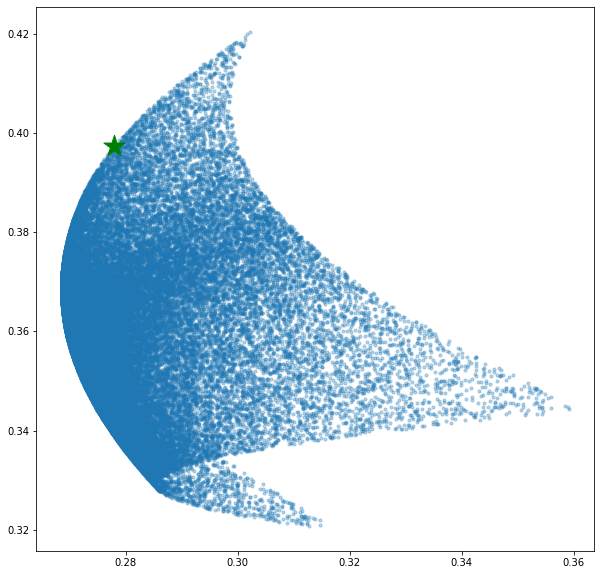

In [5]:
#Example NKE, GOOGL, FB, 3 year lookback
def main():
    current_date, lookback, stock_list = read_data()
    create_optimal_portfolio(current_date, lookback, stock_list)

if __name__ == "__main__":
    main()